In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pyBigWig

In [2]:
H3K27ac = pyBigWig.open('GSE63525/IMR90/H3K27ac.bigWig')
# H3K27me3 = pyBigWig.open('/data1/lmh_data/MINE/source/GM12878/H3K27me3.bigWig')
H3K4me3 = pyBigWig.open('GSE63525/IMR90/H3K4me3.bigWig')
CTCF = pyBigWig.open('GSE63525/IMR90/CTCF.bigWig')
POLR2A = pyBigWig.open('GSE63525/IMR90/POLR2A.bigWig')
H3K9me3 = pyBigWig.open('GSE63525/IMR90/H3K9me3.bigWig')
TADS = np.loadtxt('output/IMR90/50kb_TAD/chr19.txt')

In [8]:
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=50000, yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

#     length = ymax - ymin
    
#     ax.set_yticks([ymin + length/10, ymax - length/10])
    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [55]:
def two_degree_bc(x_l=10, x_r=90, y_lr=0, y2=10, dots_num=100): #bezier curve
    xt = []
    yt = []
    x_mid = (x_l + x_r)/2
    x_dots12 = np.linspace(x_l, x_mid, dots_num)
    y_dots12 = np.linspace(y_lr, y2, dots_num)
    x_dots23 = np.linspace(x_mid, x_r, dots_num)
    y_dots23 = np.linspace(y2, y_lr, dots_num)
    for i in range(dots_num):
        x = x_dots12[i]
        y = y_dots12[i]
        xt.append(x)
        yt.append(y)
    for i in range(dots_num):
        x = x_dots23[i]
        y = y_dots23[i]
        xt.append(x)
        yt.append(y)
    return (xt, yt)

def plot_loop(ax, ylabel, file_path, chrom: int, start: int, end: int, FDR=0.5, color='#66AC84'):
    loops = np.loadtxt(file_path)
    loops = list(filter(lambda x: ((x[0]>=start)&(x[0]<=end)|((x[1]>=start)&(x[1]<=end))), loops))
    lengths = [loop[1]-loop[0] for loop in loops]

    if len(loops) == 0:
        for i in ['top', 'right', "left", "bottom"]:
            ax.spines[i].set_color('none')
            ax.spines[i].set_linewidth(0)
        return

    top_y = 0
    for loop, length in zip(loops, lengths):
        top = 0.35
        
        xt, yt = two_degree_bc(x_l=loop[0], x_r=loop[1], y_lr=0, y2=top, dots_num=100)
        ax.plot(xt, yt, color=color)
        # ax.plot(xt, y_test, color='#66AC84')
        if max(yt) > top_y:
            top_y = max(yt)

    ax.set_xlim(start,end)
    ax.set_ylim(0,0.5)
    ax.set_ylabel(ylabel, fontsize=8, rotation=0, horizontalalignment='right',verticalalignment='center')
    for i in ['top', 'right']:
        ax.spines[i].set_color('none')
        #ax.spines[i].set_linewidth(0.5)
        
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)  
    
    
    ax.tick_params(bottom =False,top=False,left=False,right=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [5]:
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    
    plot_gene_num = gene_bed_plot.shape[0]
    print(plot_gene_num)
    if line == 1:
        for i, row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = [int(x) for x in row["blockStarts"].split(",")]
            widths = [int(x) for x in row["blockSizes"].split(",")]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if row["name"] in gene_col:
                text_col = "red"
                col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = [int(x) for x in row["blockStarts"].split(",")]
            widths = [int(x) for x in row["blockSizes"].split(",")]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
            if (gene_bed_plot.iloc[-1]['name'] == row['name']) or (gene_bed_plot.iloc[-2]['name'] == row['name']) or (gene_bed_plot.iloc[-3]['name'] == row['name']):
                ax.text(row['start'], plot_y + 0.5, row['name'] + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
            else:
                ax.text(row['end'], plot_y + 0.5, "  " + row['name'], ha='left', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [5]:
def getxy(x_l=10, x_r=90, y_lr=0, y2=10, dots_num=100): #bezier curve
    xt = []
    yt = []
    x_mid = (x_l + x_r)/2
    x_dots12 = np.linspace(x_l, x_r, dots_num)
    for i in range(dots_num):
        x = x_dots12[i]
        y = y2
        xt.append(x)
        yt.append(y)
    return (xt, yt)
def plot_AB(ax, ylabel, file_path, chrom: int, start: int, end: int, FDR=0.5, color='#66AC84'):
    ABS = np.loadtxt(file_path)
    ABS = list(filter(lambda x: ((x[0]>=start)&(x[0]<=end)|((x[1]>=start)&(x[1]<=end))), ABS))
    lengths = [ABS[1]-ABS[0] for AB in ABS]

    top_y = 0
    for AB, length in zip(ABS, lengths):
        top = 0.3
        
        xt, yt = getxy(x_l=AB[0], x_r=AB[1], y_lr=0, y2=top, dots_num=100)
        ax.plot(xt, yt, color=color)
        ax.fill_between(xt,0,0.3,facecolor=color)
        # ax.plot(xt, y_test, color='#66AC84')
        if max(yt) > top_y:
            top_y = max(yt)

    ax.set_xlim(start,end)
    ax.set_ylim(0,0.5)
    ax.set_ylabel(ylabel, fontsize=8, rotation=0, horizontalalignment='right',verticalalignment='center')
    for i in ['top', 'right']:
        ax.spines[i].set_color('none')
        #ax.spines[i].set_linewidth(0.5)
        
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)  
    
    
    ax.tick_params(bottom =False,top=False,left=False,right=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [69]:
def show(chrom, start, end, resolution, FDR=0.5):
    fig = plt.figure(figsize=(12, 8), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(13, 1)
    ax0 = fig.add_subplot(gs[0:1, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[1, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[2, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[3, 0], facecolor='white')
    ax4 = fig.add_subplot(gs[4, 0], facecolor='white')
    ax5 = fig.add_subplot(gs[5, 0], facecolor='white')
    ax6 = fig.add_subplot(gs[6, 0], facecolor='white')


    ax0.set_title("{0}:{1}-{2}".format(chrom, start, end))
    
    plot_loop(
        ax0, 'TAD in clusters\n(call by TORNADOES)',
        'output/IMR90/hypergraph/two/first.txt',
        int(chrom[3:]), start/50000, end/50000, FDR)
    plot_loop(
        ax0, 'TAD in clusters\n(call by TORNADOES)',
        'output/IMR90/hypergraph/two/second.txt',
        int(chrom[3:]), start/50000, end/50000, FDR,color=(255/255, 122/255, 23/255))
    # plot_loop(
    #     ax0, 'TAD in clusters\n(call by TORNADOES)',
    #     '/home/zsc/study/biye/output/IMR90/hypergraph/three/three.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(202/255, 73/255, 66/255))
    # plot_loop(
    #     ax0, 'TAD in clusters\n(call by TORNADOES)',
    #     '/home/zsc/study/biye/output/IMR90/hypergraph/four/four.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(141/255, 215/255, 247/255))
    
    plot_AB(
        ax1, 'A/B compartment',
        'output/IMR90/AB/A_KR.txt',
        int(chrom[3:]), start/50000, end/50000, FDR,color=(202/255, 73/255, 66/255))
    plot_AB(
        ax1, 'A/B compartment',
        'output/IMR90/AB/B_KR.txt',
        int(chrom[3:]), start/50000, end/50000, FDR,color=(32/255, 151/255, 212/255))
    # plot_AB(
    #     ax1, 'Sub-compartment',
    #     '/home/zsc/study/biye/output/IMR90/sub-compartment/A1.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(202/255, 73/255, 66/255))
    # plot_AB(
    #     ax1, 'Sub-compartment',
    #     '/home/zsc/study/biye/output/IMR90/sub-compartment/A2.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(243/255, 121/255, 55/255))
    # plot_AB(
    #     ax1, 'Sub-compartment',
    #     '/home/zsc/study/biye/output/IMR90/sub-compartment/B1.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(32/255, 151/255, 212/255))
    # plot_AB(
    #     ax1, 'Sub-compartment',
    #     '/home/zsc/study/biye/output/IMR90/sub-compartment/B2.txt',
    #     int(chrom[3:]), start/50000, end/50000, FDR,color=(141/255, 215/255, 247/255))

    plot_bwTrack(ax2, H3K27ac, "H3K27ac", chrom, start, end, resolution=resolution, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    
    plot_bwTrack(ax3, H3K4me3, "H3K4me3", chrom, start, end, resolution=resolution, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#FAD048')
    
    plot_bwTrack(ax4, CTCF, "CTCF", chrom, start, end, resolution=resolution, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#E69F00')
    
    plot_bwTrack(ax5, POLR2A, "POLR2A", chrom, start, end, resolution=resolution, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='grey')

    plot_bwTrack(ax6, H3K9me3, "H3K9me3", chrom, start, end, resolution=resolution, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#CDC9C9')

    fig.savefig("pictures/TADin2Cluster.pdf", format='pdf', bbox_inches='tight')

    plt.show()

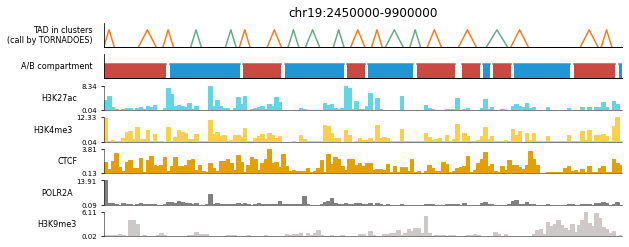

In [70]:
show("chr19", 2450000, 9900000, 50000, FDR=0.3)